#  Importing the required libraries

In [1]:
import os
import random
import sys

## Package
import glob 
from IPython.display import Audio
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.offline as py
import seaborn as sns
import scipy.io.wavfile


from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.mixture import GaussianMixture

import pickle

from sklearn.metrics import confusion_matrix

from scipy import signal
from scipy.io import wavfile
from tqdm import tqdm
input_duration=3

# Accessing the dataset directory
Accessing the directory where dataset are stored in local system

In [2]:
# Accessing RAVDESS DataSet Directory
dir_list = os.listdir('data/')
dir_list.sort()
print (dir_list)

#Accessing SAVEE dataset directory
dir_list1 = os.listdir('data1/')
dir_list1.sort()
print (dir_list1)

['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']
['Actor_25', 'Actor_26', 'Actor_27', 'Actor_28']


# Creating dataframe for RAVDESS

Creating Dataframe our `RAVDESS` dataset. From the `RAVDESS` dataset, we have only used the audio file. The dataframe has two columns `path` and `emotion`. 
Filename of the audio consists of a 7-part numerical identifier (e.g., 03-01-06-01-02-01-12.wav).
Filename Identifiers-
- Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
- Vocal channel (01 = speech, 02 = song).
- Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
- Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
- Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
- Repetition (01 = 1st repetition, 02 = 2nd repetition).
- Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).  

Here, I am trying to split the audio filename and getting the type of emotion

In [3]:
# Create Dataframe for RAVDESS
data_df = pd.DataFrame(columns=['path', 'emotion'])
count = 0
for i in dir_list:
    file_list = os.listdir('data/' + i)
    for f in file_list:
        nm = f.split('.')[0].split('-')
        path = 'data/' + i + '/' + f
        emotion = int(nm[2])
            
        data_df.loc[count] = [path, emotion]
        count += 1

In [4]:
print (len(data_df))
data_df.head()

1440


,path,emotion
0,data/Actor_01/03-01-01-01-01-01-01.wav,1
1,data/Actor_01/03-01-01-01-01-02-01.wav,1
2,data/Actor_01/03-01-01-01-02-01-01.wav,1
3,data/Actor_01/03-01-01-01-02-02-01.wav,1
4,data/Actor_01/03-01-02-01-01-01-01.wav,2


### Finding the label
Instead of using numbers as label, assigning label name to the numbers. Also the `RAVDESS` dataset contains many emotion. We want only `Happy`, `Angry`, `Sad` and `Neutral` emotion. So assigning the other emotions to `None`.

In [5]:
label_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 1:
        lb = "neutral"
    elif data_df.emotion[i] == 3:
        lb = "happy"
    elif data_df.emotion[i] == 4:
        lb = "sad"
    elif data_df.emotion[i] == 5:
        lb = "angry"
    else:
        lb = "none"
    label_list.append(lb)
    
len(label_list)

1440

### Adding label column
Here, we are adding the `label` column in the `data_df` dataframe created above for `RAVDESS` dataset.

In [6]:
data_df['label'] = label_list
data_df.head()

,path,emotion,label
0,data/Actor_01/03-01-01-01-01-01-01.wav,1,neutral
1,data/Actor_01/03-01-01-01-01-02-01.wav,1,neutral
2,data/Actor_01/03-01-01-01-02-01-01.wav,1,neutral
3,data/Actor_01/03-01-01-01-02-02-01.wav,1,neutral
4,data/Actor_01/03-01-02-01-01-01-01.wav,2,none


### Dropping the emotion column
Since we got our label name, we dropped the emotion column which was in numbers.

In [7]:
data_df=data_df.drop(columns=['emotion'])

### Dropping the none
We are dropping the rows with the label equals to `none` because they are the other emotions that we dont want. 

In [8]:
data_df = data_df[data_df.label != 'none'].reset_index(drop=True)
data_df.label.value_counts()

sad        192
angry      192
happy      192
neutral     96
Name: label, dtype: int64

In [9]:
len(data_df)
data_df.head()

,path,label
0,data/Actor_01/03-01-01-01-01-01-01.wav,neutral
1,data/Actor_01/03-01-01-01-01-02-01.wav,neutral
2,data/Actor_01/03-01-01-01-02-01-01.wav,neutral
3,data/Actor_01/03-01-01-01-02-02-01.wav,neutral
4,data/Actor_01/03-01-03-01-01-01-01.wav,happy


# Creating Dataframe for SAVEE

Creating dataframe for `SAVEE` dataset. Also, trying to split the filename and getting the type of emotion. In this case, we are creating a dataframe which has `path` and `label` as columns.

In [10]:
# Create DataFrame for Data
data_df1 = pd.DataFrame(columns=['path', 'label'])
count = 0
for i in dir_list1:
    file_list = os.listdir('data1/' + i)
    for f in file_list:
        nm = f.split('.')[0]
        path = 'data1/' + i + '/' + f
        src = nm[0]
        if nm[0]=='a':
            lb="angry"
        elif nm[0]=='h':
            lb = "happy"
        elif nm[0]=='s':
            lb = "sad"
        elif nm[0]=='n':
            lb = "neutral"
        
            
        data_df1.loc[count] = [path, lb]
        count += 1

In [11]:
data_df1.head()
print(data_df1.label.value_counts())
print(data_df.label.value_counts())

neutral    120
sad         60
happy       60
angry       60
Name: label, dtype: int64
sad        192
angry      192
happy      192
neutral     96
Name: label, dtype: int64


### Combining dataframe of the two datasets

In [12]:
data = pd.concat([data_df, data_df1], axis=0, sort=True).reset_index(drop=True)

#### Function to plot the data distribution of the emotion class

In [13]:
# Plotting the emotion distribution

def plot_emotion_dist(dist, color_code='#C2185B', title="Plot"):
    """
    To plot the data distributioin by class.
    Arg:
      dist: pandas series of label count. 
    """
    tmp_df = pd.DataFrame()
    tmp_df['Emotion'] = list(dist.keys())
    tmp_df['Count'] = list(dist)
    fig, ax = plt.subplots(figsize=(14, 7))
    ax = sns.barplot(x="Emotion", y='Count', color=color_code, data=tmp_df)
    ax.set_title(title)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45)

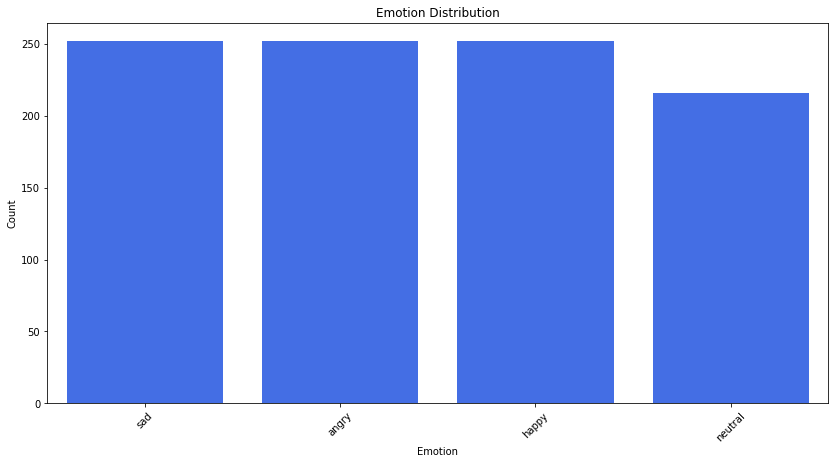

In [14]:
a = data.label.value_counts()
plot_emotion_dist(a, "#2962FF", "Emotion Distribution")

In [15]:
len(data)

972

In [16]:
filename = data.path[870]
print (filename)

samples, sample_rate = librosa.load(filename, sr=16000)
sample_rate,samples
Audio(data=samples,rate=sample_rate)

data1/Actor_27/n19.wav


# Separating the dataset for different emotion
Here, we are separating the dataframe for each emotion to create GMM model for each emotion class.

In [17]:
#happy dataset
df_happy=data[data.label=='happy']
df_happy=df_happy.reset_index(drop=True)
print(df_happy.head())

#angry dataset
df_angry=data[data.label=='angry']
df_angry=df_angry.reset_index(drop=True)
print(df_angry.head())

#sad dataset
df_sad=data[data.label=='sad']
df_sad=df_sad.reset_index(drop=True)
print(df_sad.head())

#neutral dataset
df_neutral=data[data.label=='neutral']
df_neutral=df_neutral.reset_index(drop=True)
print(df_neutral.head())


   label                                    path
0  happy  data/Actor_01/03-01-03-01-01-01-01.wav
1  happy  data/Actor_01/03-01-03-01-01-02-01.wav
2  happy  data/Actor_01/03-01-03-01-02-01-01.wav
3  happy  data/Actor_01/03-01-03-01-02-02-01.wav
4  happy  data/Actor_01/03-01-03-02-01-01-01.wav
   label                                    path
0  angry  data/Actor_01/03-01-05-01-01-01-01.wav
1  angry  data/Actor_01/03-01-05-01-01-02-01.wav
2  angry  data/Actor_01/03-01-05-01-02-01-01.wav
3  angry  data/Actor_01/03-01-05-01-02-02-01.wav
4  angry  data/Actor_01/03-01-05-02-01-01-01.wav
  label                                    path
0   sad  data/Actor_01/03-01-04-01-01-01-01.wav
1   sad  data/Actor_01/03-01-04-01-01-02-01.wav
2   sad  data/Actor_01/03-01-04-01-02-01-01.wav
3   sad  data/Actor_01/03-01-04-01-02-02-01.wav
4   sad  data/Actor_01/03-01-04-02-01-01-01.wav
     label                                    path
0  neutral  data/Actor_01/03-01-01-01-01-01-01.wav
1  neutral  data/Actor

#### Function for plotting the log spectrogram for audio of each emotion class

In [18]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

data/Actor_01/03-01-03-01-01-01-01.wav
data/Actor_01/03-01-03-01-01-01-01.wav
data/Actor_01/03-01-03-01-01-01-01.wav
data/Actor_01/03-01-03-01-01-01-01.wav


Text(0.5,0,'Seconds')

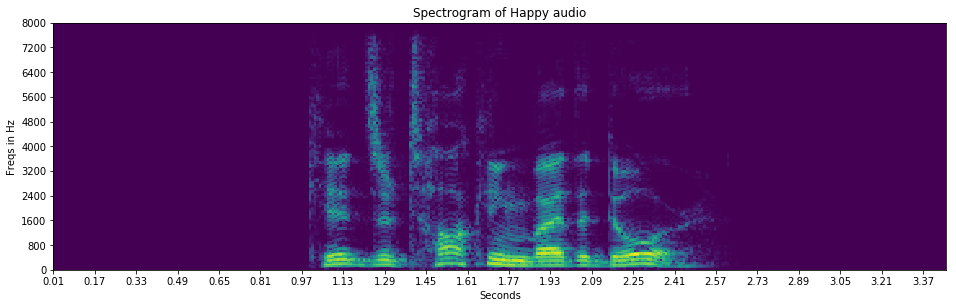

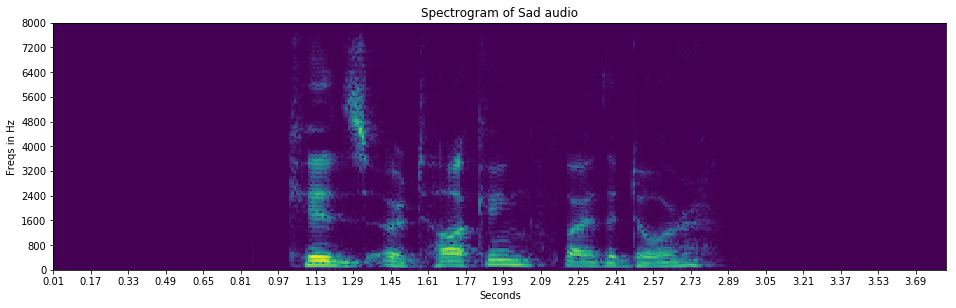

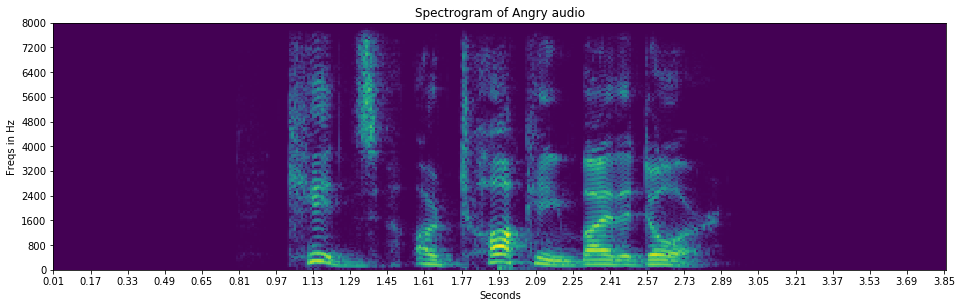

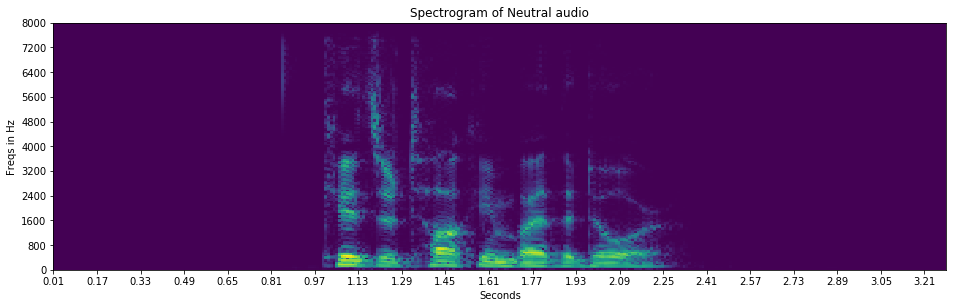

In [19]:
samples, sample_rate = librosa.load(df_happy.path[0], sr=16000)
print(df_happy.path[0])
# Plotting Wave Form and Spectrogram
freqs, times, spectrogram = log_specgram(samples, sample_rate)

fig = plt.figure(figsize=(16, 10))

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of Happy audio')
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')


samples, sample_rate = librosa.load(df_sad.path[0], sr=16000)
print(df_happy.path[0])
# Plotting Wave Form and Spectrogram
freqs, times, spectrogram = log_specgram(samples, sample_rate)

fig = plt.figure(figsize=(16, 10))

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of Sad audio')
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')


samples, sample_rate = librosa.load(df_angry.path[0], sr=16000)
print(df_happy.path[0])
# Plotting Wave Form and Spectrogram
freqs, times, spectrogram = log_specgram(samples, sample_rate)

fig = plt.figure(figsize=(16, 10))

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of Angry audio')
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')


samples, sample_rate = librosa.load(df_neutral.path[0], sr=16000)
print(df_happy.path[0])
# Plotting Wave Form and Spectrogram
freqs, times, spectrogram = log_specgram(samples, sample_rate)

fig = plt.figure(figsize=(16, 10))

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of Neutral audio')
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

# Data Splitting

Here, `data_split` function splits each emotion dataframe for training and testing.

In [20]:
#  Stratified Shuffle Split Method
def data_split(X,Y):
    xxx = StratifiedShuffleSplit(1, test_size=0.2, random_state=12)
    for train_index, test_index in xxx.split(X, Y):
        train, test = X.iloc[train_index], X.iloc[test_index]
        label_train, label_test = Y.iloc[train_index], Y.iloc[test_index]
    df=pd.DataFrame(columns=["path"])
    df=pd.DataFrame(train)
    df=df.reset_index(drop=True)
    test=test.reset_index(drop=True)
    label_test=label_test.reset_index(drop=True)
    return (df,test,label_test)

Here, the `data_split` function is called and the emotion dataframe are splitted. And atlast all the testing dataframe are combined togther for testing purpose.

In [21]:
#happy dataset splitting
X=df_happy["path"]
Y=df_happy["label"]

d_happy,happy_test,happy_label_test=data_split(X,Y)

## sad dataset splitting
X=df_sad["path"]
Y=df_sad["label"]
d_sad,sad_test,sad_label_test=data_split(X,Y)



## angry dataset splitting
X=df_angry["path"]
Y=df_angry["label"]
d_angry,angry_test,angry_label_test=data_split(X,Y)

## sad dataset splitting
X=df_neutral["path"]
Y=df_neutral["label"]
d_neutral,neutral_test,neutral_label_test=data_split(X,Y)

test = pd.concat([happy_test,sad_test, angry_test,neutral_test], axis=0, sort=True).reset_index(drop=True)
test_label = pd.concat([happy_label_test, sad_label_test, angry_label_test, neutral_label_test], axis=0, sort=True).reset_index(drop=True)


# Feature Extraction

Here, `feature_extraction` function extract the features from each audio files. The features that we are extracting here is the `13 MFCC coefficient` of the audio file. The features are saved in an array and the features of audio are vertically stack with the features of another audio.

In [22]:
def feature_extraction(df):
    data = np.asarray(())
    for i in tqdm(range(len(df))):
        X, sample_rate = librosa.load(df.path[i], res_type='kaiser_fast',duration=input_duration,sr=16000,offset=0.5)

        sample_rate = np.array(sample_rate)
        mfccs = librosa.feature.mfcc(y=X, sr=sample_rate, hop_length=int(0.010*sample_rate), n_fft=int(0.020*sample_rate), n_mfcc=13)
        feature = mfccs.transpose()
        mfcc_delta=librosa.feature.delta(feature)
        mfcc_delta2=librosa.feature.delta(feature, order=2)
        ener = librosa.feature.rmse(y=X, frame_length= int(0.020*sample_rate), hop_length = int(0.010* sample_rate))
        ener=ener.transpose()
        feature= np.hstack((feature, mfcc_delta, mfcc_delta2, ener))
        if data.size==0:
            data = feature
        else:
            data = np.vstack((data,feature))
            
    return np.array(data)

In [23]:
#Feature extraction for happy dataset    
happy=feature_extraction(d_happy)

  0%|                                                                                          | 0/201 [00:00<?, ?it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

E:\Anaconda\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

  0%|▍                                                                                 | 1/201 [00:00<00:49,  4.01it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fma

 14%|███████████▋                                                                     | 29/201 [00:01<00:08, 20.45it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 16%|████████████▉                                                                    | 32/201 [00:01<00:07, 21.40it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detec

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 31%|████████████████████████▉                                                        | 62/201 [00:02<00:06, 22.12it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or

 46%|█████████████████████████████████████                                            | 92/201 [00:04<00:05, 21.29it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 47%|██████████████████████████████████████▎                                          | 95/201 [00:04<00:05, 20.80it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detec

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 61%|████████████████████████████████████████████████▉                               | 123/201 [00:06<00:04, 18.12it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 77%|█████████████████████████████████████████████████████████████▎                  | 154/201 [00:07<00:02, 18.43it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 92%|█████████████████████████████████████████████████████████████████████████▏      | 184/201 [00:09<00:00, 18.69it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 93%|██████████████████████████████████████████████████████████████████████████      | 186/201 [00:09<00:00, 18.90it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detec

In [24]:
#Feature Extraction for angry dataset
angry=feature_extraction(d_angry)

  0%|                                                                                          | 0/201 [00:00<?, ?it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

E:\Anaconda\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

  0%|▍                                                                                 | 1/201 [00:00<00:23,  8.47it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fma

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 15%|████████████▍                                                                    | 31/201 [00:01<00:07, 22.21it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or

 30%|████████████████████████▌                                                        | 61/201 [00:04<00:07, 18.64it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 32%|█████████████████████████▊                                                       | 64/201 [00:04<00:07, 19.40it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detec

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 47%|█████████████████████████████████████▉                                           | 94/201 [00:05<00:04, 22.13it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 61%|████████████████████████████████████████████████▉                               | 123/201 [00:07<00:04, 19.13it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or

 76%|████████████████████████████████████████████████████████████▉                   | 153/201 [00:08<00:02, 17.91it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 77%|█████████████████████████████████████████████████████████████▋                  | 155/201 [00:08<00:02, 18.41it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detec

 91%|████████████████████████████████████████████████████████████████████████▊       | 183/201 [00:10<00:00, 19.18it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 93%|██████████████████████████████████████████████████████████████████████████      | 186/201 [00:10<00:00, 19.53it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detec

In [25]:
#Feature extraction for sad emotion
sad=feature_extraction(d_sad)   

  0%|                                                                                          | 0/201 [00:00<?, ?it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

E:\Anaconda\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in m

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 16%|████████████▉                                                                    | 32/201 [00:01<00:07, 22.75it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or

 30%|████████████████████████▌                                                        | 61/201 [00:02<00:07, 19.21it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 32%|█████████████████████████▊                                                       | 64/201 [00:03<00:06, 19.75it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detec

 46%|█████████████████████████████████████                                            | 92/201 [00:04<00:05, 19.21it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 47%|██████████████████████████████████████▎                                          | 95/201 [00:04<00:05, 18.94it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detec

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 61%|████████████████████████████████████████████████▉                               | 123/201 [00:06<00:04, 17.73it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 77%|█████████████████████████████████████████████████████████████▎                  | 154/201 [00:07<00:02, 18.63it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or

 92%|█████████████████████████████████████████████████████████████████████████▏      | 184/201 [00:09<00:00, 17.65it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 93%|██████████████████████████████████████████████████████████████████████████      | 186/201 [00:09<00:00, 17.48it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detec

In [26]:
#Feature extraction for neutral emotion
neutral=feature_extraction(d_neutral)  

  0%|                                                                                          | 0/172 [00:00<?, ?it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

E:\Anaconda\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in m

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 18%|██████████████▌                                                                  | 31/172 [00:01<00:06, 20.89it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or

 35%|████████████████████████████▋                                                    | 61/172 [00:02<00:05, 21.96it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 37%|██████████████████████████████▏                                                  | 64/172 [00:02<00:04, 21.75it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detec

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 55%|████████████████████████████████████████████▎                                    | 94/172 [00:04<00:03, 20.49it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or

 72%|█████████████████████████████████████████████████████████▋                      | 124/172 [00:05<00:02, 19.42it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 74%|███████████████████████████████████████████████████████████                     | 127/172 [00:06<00:02, 19.65it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detec

 90%|███████████████████████████████████████████████████████████████████████▋        | 154/172 [00:07<00:01, 17.36it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 91%|████████████████████████████████████████████████████████████████████████▌       | 156/172 [00:07<00:00, 17.65it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detec

# Scatter Plot for each emotion class

Here, `compress` function is compressing our multidimensional features into 2 components using Principal Component Analysis (PCA) for simplicity in the ploting the features in 2D plot.

In [27]:
from sklearn.decomposition import PCA
def compress(emotion):
    pca=PCA(n_components=2)
    new_emotion= pca.fit_transform(emotion)
    return new_emotion.transpose()


Text(0.5,1,'Neutral')

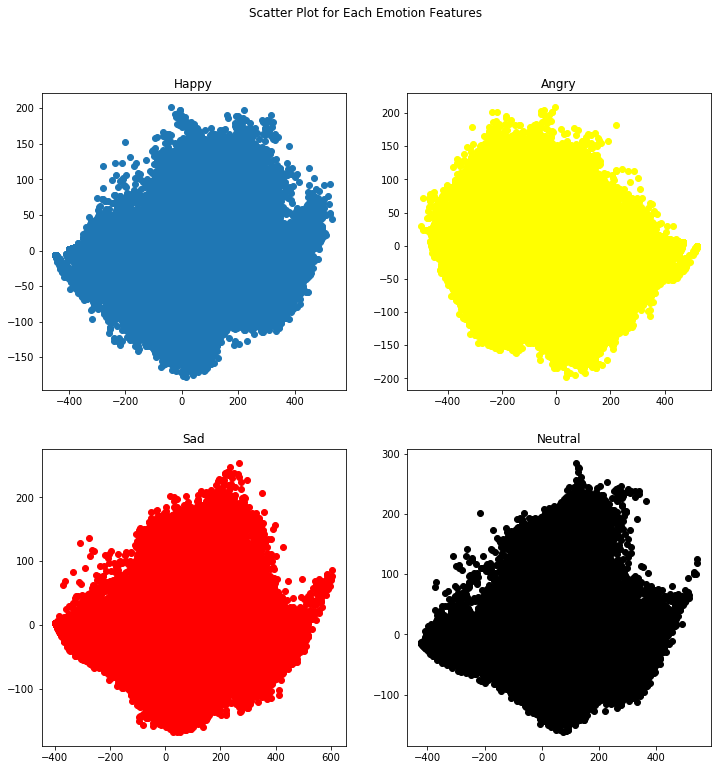

In [28]:
fig=plt.figure(figsize=(12,12))
plt.suptitle("Scatter Plot for Each Emotion Features")
t1=compress(happy)
plt.subplot(2,2,1)
plt.scatter(t1[0], t1[1])
plt.title("Happy")

t2=compress(angry)
plt.subplot(2,2,2)
plt.scatter(t2[0], t2[1],c="yellow")
plt.title('Angry')

t3=compress(sad)
plt.subplot(2,2,3)
plt.scatter(t3[0], t3[1],c="red")
plt.title('Sad')

t4=compress(neutral)
plt.subplot(2,2,4)
plt.scatter(t4[0], t4[1],c="black")
plt.title('Neutral')

# Training

Here, `train_model` function take the `features` matrix as a parameter and train the GMM model for each emotion using 512 components.

In [ ]:
def train_model(features):
    gmm = GaussianMixture(n_components=512).fit(features)
    labels = gmm.predict(features)
    return (gmm,labels)

In [ ]:
#Train Emotion
#happy model
gmm_happy,labels=train_model(happy)
#angry model
gmm_angry,labels= train_model(angry)
#sad model
gmm_sad,labels= train_model(sad)
#neutral model
gmm_neutral,labels = train_model(neutral)

# Save Model

`save_model` function save the trained model in local system for future use since the training model takes times and incase of GMM, the seed point changes everytime and the accuracy vary.

In [ ]:
def save_model(model,name):
    save_dir = os.path.join(os.getcwd(), 'Models')
    # Save model and weights
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    filename = name+'.sav'
    model_path = os.path.join(save_dir, filename)
    print(model_path)
    pickle.dump(model, open(model_path, 'wb'))

In [ ]:
#save happy model
save_model(gmm_happy, "happy_model")
#save angry model
save_model(gmm_angry, "angry_model")
#save sad model
save_model(gmm_sad, "sad_model")
#save neutral model
save_model(gmm_neutral, "neutral_model")

# Test Model

`test_model` function takes all the trained model and the testing dataset as a parameter. Here, the features extracted for each audio is evaluated against each emotion model and the log-likelihood is computed. The emotion with the highest log-likehood is the classification decision.

In [29]:
def test_model(gmm_happy,gmm_angry,gmm_sad,gmm_neutral,data):
    predict = pd.DataFrame(columns=['predict'])
    for i in tqdm(range(len(data))):
        X, sample_rate = librosa.load(data[i], res_type='kaiser_fast',duration=input_duration,sr=16000,offset=0.5)

        sample_rate = np.array(sample_rate)
        mfccs = librosa.feature.mfcc(y=X, sr=sample_rate, hop_length=int(0.010*sample_rate), n_fft=int(0.020*sample_rate), n_mfcc=13)
        feature = mfccs.transpose()
        mfcc_delta=librosa.feature.delta(feature)
        mfcc_delta2=librosa.feature.delta(feature, order=2)
        ener = librosa.feature.rmse(y=X, frame_length= int(0.020*sample_rate), hop_length = int(0.010* sample_rate))
        ener=ener.transpose()
        feature= np.hstack((feature, mfcc_delta, mfcc_delta2, ener))
        happy_score= gmm_happy.score(feature)
        angry_score= gmm_angry.score(feature)
        sad_score= gmm_sad.score(feature)
        neutral_score= gmm_neutral.score(feature)
        dicta = {
            "happy": happy_score,
            "angry": angry_score,
            "sad": sad_score,
            "neutral": neutral_score
        }
        x=max(dicta, key=dicta.get)
        predict.loc[i]=x
    return predict

# Running Continuously

Running an infinite `while` loop to get an accuracy threshold because the seed point is randomized in GMM and the accuracy differ each time we train our model. The accuracy increase or decrease, so as to get the maximum accuracy we are running an infinite loop until we get a maximum accuracy we have seen before.

In [ ]:
## Run Continuously until you find good result
while(True):
    gmm_happy,label1=train_model(happy)
    gmm_angry,label2=train_model(angry)
    gmm_sad,label3=train_model(sad)
    gmm_neutral,label4=train_model(neutral)
    
    predict  = test_model(gmm_happy,gmm_angry,gmm_sad,gmm_neutral,test)
    
    c=confusion_matrix(test_label, predict)
    
    acc=accuracy(c)
    if acc >= 0.88:
        #save happy model
        save_model(gmm_happy, "happy_model")
        #save angry model
        save_model(gmm_angry, "angry_model")
        #save sad model
        save_model(gmm_sad, "sad_model")
        #save neutral model
        save_model(gmm_neutral, "neutral_model")
        break
    print(acc)
    

# Load Model

Loading saved model from the local system so that we don't have to train the model everytime we run our code.

In [30]:
def load_model(name):
    with open('AnotherCombinedModels/'+name+".sav", 'rb') as pickle_file:
        return pickle.load(pickle_file)

In [31]:
gmm_happy= load_model("happy_model")
gmm_angry= load_model("angry_model")
gmm_sad=load_model("sad_model")
gmm_neutral=load_model("neutral_model")

# Testing your Test DataSet

In [32]:
#Tesing for test data set 
predict  = test_model(gmm_happy,gmm_angry,gmm_sad,gmm_neutral,test)  

  0%|                                                                                          | 0/197 [00:00<?, ?it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

E:\Anaconda\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

  1%|▍                                                                                 | 1/197 [00:00<01:19,  2.45it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fma

 12%|█████████▍                                                                       | 23/197 [00:09<01:07,  2.58it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 12%|█████████▊                                                                       | 24/197 [00:09<01:07,  2.57it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 13%|██████████▎                                                                      | 25/197 [00:09<01:07,  2.55it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate 

 24%|███████████████████▎                                                             | 47/197 [00:18<00:57,  2.60it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 24%|███████████████████▋                                                             | 48/197 [00:18<00:57,  2.60it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 25%|████████████████████▏                                                            | 49/197 [00:19<00:57,  2.60it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate 

 36%|█████████████████████████████▏                                                   | 71/197 [00:27<00:49,  2.57it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 37%|█████████████████████████████▌                                                   | 72/197 [00:28<00:48,  2.59it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 37%|██████████████████████████████                                                   | 73/197 [00:28<00:49,  2.53it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate 

 48%|███████████████████████████████████████                                          | 95/197 [00:37<00:39,  2.56it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 49%|███████████████████████████████████████▍                                         | 96/197 [00:37<00:39,  2.58it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 49%|███████████████████████████████████████▉                                         | 97/197 [00:38<00:39,  2.56it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate 

 60%|████████████████████████████████████████████████▎                               | 119/197 [00:46<00:29,  2.63it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 61%|████████████████████████████████████████████████▋                               | 120/197 [00:46<00:29,  2.61it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 61%|█████████████████████████████████████████████████▏                              | 121/197 [00:47<00:27,  2.74it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate 

 73%|██████████████████████████████████████████████████████████                      | 143/197 [00:55<00:21,  2.55it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 73%|██████████████████████████████████████████████████████████▍                     | 144/197 [00:56<00:20,  2.60it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 74%|██████████████████████████████████████████████████████████▉                     | 145/197 [00:56<00:20,  2.56it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate 

 85%|███████████████████████████████████████████████████████████████████▊            | 167/197 [01:04<00:10,  2.85it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 85%|████████████████████████████████████████████████████████████████████▏           | 168/197 [01:05<00:10,  2.76it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 86%|████████████████████████████████████████████████████████████████████▋           | 169/197 [01:05<00:08,  3.35it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate 

 97%|█████████████████████████████████████████████████████████████████████████████▌  | 191/197 [01:13<00:02,  2.39it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 97%|█████████████████████████████████████████████████████████████████████████████▉  | 192/197 [01:14<00:01,  2.50it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 193/197 [01:14<00:01,  2.41it/s]E:\Anaconda\lib\site-packages\librosa\filters.py:284: UserWarning:

Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate 

In [33]:
predict.predict.value_counts()

angry      54
happy      52
sad        47
neutral    44
Name: predict, dtype: int64

# Constructing Confusion Matrix

In [34]:
c=confusion_matrix(test_label, predict)
c

array([[49,  1,  0,  1],
       [ 3, 47,  0,  1],
       [ 0,  1, 41,  2],
       [ 2,  3,  3, 43]], dtype=int64)

`plot_confusion_matrix` function help us to plot the confusion matrix for multi label dataset.

In [35]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]*100


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

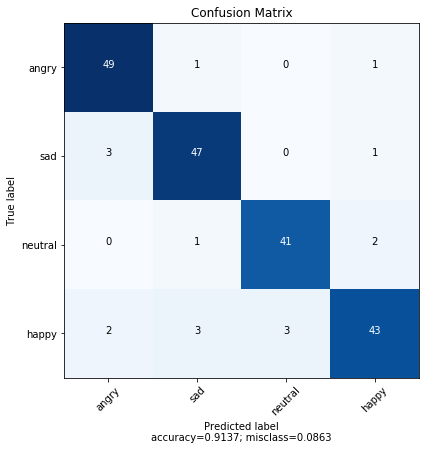

In [36]:
labels=["angry","sad","neutral","happy"]

plot_confusion_matrix(cm = c, 
                      normalize    = False,
                      target_names = labels,
                      title        = "Confusion Matrix")


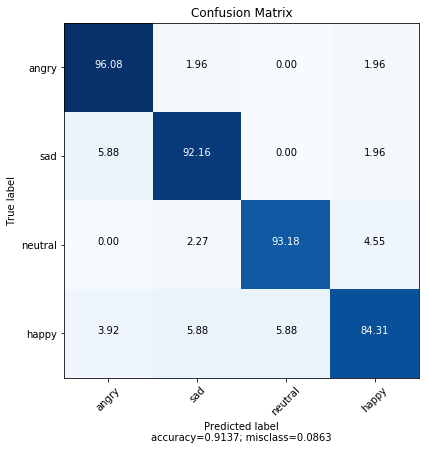

In [37]:
plot_confusion_matrix(cm = c, 
                      normalize    = True,
                      target_names = labels,
                      title        = "Confusion Matrix")

# Accuracy

In [38]:
def accuracy(confusion_matrix):
    diagonal_sum = confusion_matrix.trace()
    sum_of_all_elements = confusion_matrix.sum()
    return diagonal_sum / sum_of_all_elements 

In [39]:
accuracy(c)

0.9137055837563451

# ROC Curve

In [40]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
testing_label= label_binarize(test_label, classes=["happy","angry","sad","neutral"])
testing_predict= label_binarize(predict, classes=["happy","angry","sad","neutral"])

In [41]:

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(testing_label[:, i], testing_predict[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(testing_label.ravel(), testing_predict.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

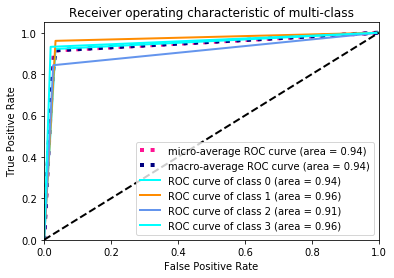

In [42]:
from scipy import interp
from itertools import cycle
lw=2
n_classes=4
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of multi-class')
plt.legend(loc="lower right")
plt.show()